## 1.1 Расширение линейной регрессии
### L1
L1 регуляризация написана на основе соответствующей функции: $L' = L + \lambda \sum |w_i|$
К итоговой loss функции добавляется штраф от регулятора
### L2
L2 регуляризация имеет следующую математическую запись: $L' = L + \lambda \sum |w_i|$
Данный регулятор математически уже реализован в PyTorch, через критерий weight_decay
### Early stopping
Для реализации ранней остановки, алгоритм пришлось изменить.
Параметры ранней остановки:
* patience - предел эпох без улучшения;
* min_delta - минимальное изменение (улучшение);
* best_val_loss - лучшая валидационная потеря;
* patience_counter - счетчик эпох без улучшения;
* best_model_state - сохранение лучшего состояния модели.
Ход реализации:
* Датасет разбит на тренировочные данные и валидационные.
* Во время валидации подсчитывается loss функция.
* Если loss функция значительно изменилась, обучение продолжается.
* Если loss функция изменилась незначительно - увеличиваем счётчик.
* Если счётчик превысил предел - остановка алгоритма обучения.

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from utils import make_regression_data, mse, log_epoch, RegressionDataset

class LinearRegression(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.linear = nn.Linear(in_features, 1)

    def forward(self, x):
        return self.linear(x)

def Model_learning_regression(train, validate):
    # Создаём модель, функцию потерь и оптимизатор
    model = LinearRegression(in_features=1)
    criterion = nn.MSELoss()
    # Критерии l1_lambda и l2_lambda для регуляторов
    l1_lambda = 0.01
    l2_lambda = 0.01
    # weight_decay для реализации L2 регуляризации
    optimizer = optim.SGD(model.parameters(), lr=0.1, weight_decay=l2_lambda)

    # Параметры Early stopping
    patience = 5
    min_delta = 0.001
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    # Обучаем модель
    epochs = 100
    for epoch in range(1, epochs + 1):
        total_loss = 0
        # Тренировка модели
        for i, (batch_X, batch_y) in enumerate(train):
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            # L1 регуляризация
            l1_norm = sum(torch.linalg.norm(p, 1) for p in model.parameters())
            loss += l1_lambda * l1_norm

            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / (i + 1)

        # Валидация модели
        model.eval() # Устанавливаем модель в режим оценки
        total_val_loss = 0
        with torch.no_grad(): # Отключаем расчет градиентов
            for batch_X, batch_y in validate:
                y_pred = model(batch_X)
                val_loss = criterion(y_pred, batch_y)
                total_val_loss += val_loss.item()
        avg_val_loss = total_val_loss / len(validate)

        if epoch % 1 == 0:
            log_epoch(epoch, avg_loss)

        # Early stopping
        if avg_val_loss < best_val_loss - min_delta:
            best_val_loss = avg_val_loss
            patience_counter = 0 # Сбрасываем счетчик, так как было улучшение
            best_model_state = model.state_dict() # Сохраняем состояние лучшей модели
        else:
            patience_counter += 1 # Увеличиваем счетчик, так как улучшения не было

        if patience_counter >= patience:
            print(f"\nEarly stopping на эпохе {epoch}. Валидационные потери не улучшались в течение {patience} эпох.")
            break # Прерываем цикл обучения

if __name__ == '__main__':
    X, y = make_regression_data(n=200)

    # Создаём датасет и разбиваем его на тренировочный и валидационный
    dataset = RegressionDataset(X, y)
    train_size = int(0.8 * len(dataset))
    validate_size = len(dataset) - train_size
    train_dataset, validate_dataset = random_split(dataset, [train_size, validate_size])

    # Создаём даталоадеры для обоих наборов
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validate_dataloader = DataLoader(validate_dataset, batch_size=32, shuffle=True)

    print(f'Размер тренировочного датасета: {train_size}')
    print(f'Размер валидационного датасета: {validate_size}')
    print(f'Количество батчей: {len(train_dataloader)}')
    Model_learning_regression(train_dataloader, validate_dataloader)

KeyboardInterrupt: 

## 1.2 Расширение логистической регрессии (15 баллов)

Чтобы выполнить все три условия, нужно проделать несколько махинаций над базовой моделью:
1) Изменить инициализацию LogisticRegression для нескольких классов
2) Выгрузить и использовать CrossEntropyLoss для многоклассовой классификации
3) Изменить утилиту make_classification_data для генерации данных под несколько классов с использованием библиотеки scikit-learn
4) Использовать из torchmetrics метрики для быстрой и удобной оценки моделей на PyTorch, оценить и вывести результат
5) Визуализировать графики с помощью matplotlib и seaborn



Размер полного датасета: 1000
Размер тренировочного датасета: 800
Размер валидационного датасета: 200
Количество батчей в тренировочном даталоадере: 13
Количество батчей в валидационном даталоадере: 4

Начало обучения...
Эпоха 010 | Потери: 0.384339
Эпоха 020 | Потери: 0.341290
Эпоха 030 | Потери: 0.331056
Эпоха 040 | Потери: 0.320299
Эпоха 050 | Потери: 0.318821
Эпоха 060 | Потери: 0.319377
Эпоха 070 | Потери: 0.322441
Эпоха 080 | Потери: 0.316322
Эпоха 090 | Потери: 0.314977
Эпоха 100 | Потери: 0.319541
Модель сохранена как 'multiclass_logreg_torch.pth'

Оценка модели на валидационном наборе...

Финальные метрики на валидационном наборе:
- Accuracy: 0.8899999856948853
- Precision: 0.8915343880653381
- Recall: 0.8906774520874023
- F1Score: 0.8897050619125366
- AUROC: 0.9665742516517639


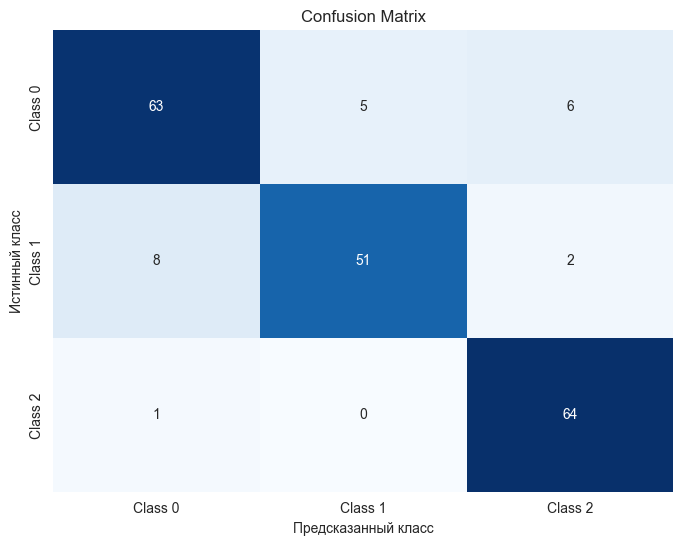

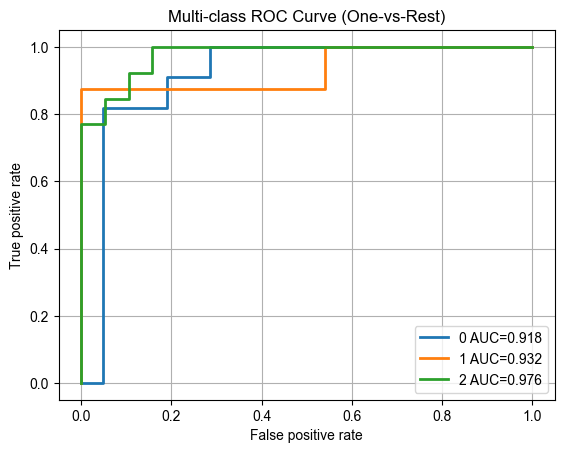

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torchmetrics
from utils import log_epoch, make_classification_data

class LogisticRegression(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.linear = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.linear(x) # Возвращаем логиты

def Model_learning_classification(num_classes, in_features, train, validate):
    # Создаём модель, функцию потерь и оптимизатор
    model = LogisticRegression(in_features=in_features, num_classes=num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # Инициализация метрик с помощью torchmetrics
    metrics = {
        "Accuracy": torchmetrics.Accuracy(task="multiclass", num_classes=num_classes),
        "Precision": torchmetrics.Precision(task="multiclass", num_classes=num_classes, average='macro'),
        "Recall": torchmetrics.Recall(task="multiclass", num_classes=num_classes, average='macro'),
        "F1Score": torchmetrics.F1Score(task="multiclass", num_classes=num_classes, average='macro'),
        # AUROC даст нам скаляр для оценки, ROCAUC - два тензора для построения графика
        "AUROC": torchmetrics.AUROC(task="multiclass", num_classes=num_classes, average='macro'),
        "ROCAUC": torchmetrics.ROC(task="multiclass", num_classes=num_classes)
    }

    # Обучаем модель
    epochs = 100
    print("\nНачало обучения...")
    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = 0

        # Обнуляем метрики для новой эпохи
        for metric_name in metrics:
            metrics[metric_name].reset()

        for i, (batch_X, batch_y) in enumerate(train):
            optimizer.zero_grad()
            logits = model(batch_X) # Логиты
            loss = criterion(logits, batch_y) # batch_y должен быть LongTensor

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Обновляем метрики
            probs = torch.softmax(logits, dim=1)
            predicted_classes = torch.argmax(logits, dim=1)

            metrics["Accuracy"].update(predicted_classes, batch_y)
            metrics["Precision"].update(predicted_classes, batch_y)
            metrics["Recall"].update(predicted_classes, batch_y)
            metrics["F1Score"].update(predicted_classes, batch_y)
            metrics["AUROC"].update(probs, batch_y)
            metrics["ROCAUC"].update(probs, batch_y)


        avg_loss = total_loss / len(train)

        # Вычисляем финальные метрики для эпохи
        epoch_metrics = {name: metric.compute().item() if isinstance(metric.compute(), torch.Tensor) else metric.compute()
                         for name, metric in metrics.items()}

        if epoch % 10 == 0:
            log_epoch(epoch, avg_loss, metrics=epoch_metrics)

    # Сохраняем модель
    torch.save(model.state_dict(), 'models/multiclass_logreg_torch.pth')
    print("Модель сохранена как 'multiclass_logreg_torch.pth'")

    # Загружаем модель для оценки
    new_model = LogisticRegression(in_features=in_features, num_classes=num_classes)
    new_model.load_state_dict(torch.load('models/multiclass_logreg_torch.pth'))
    new_model.eval() # Устанавливаем модель в режим оценки

    # Оценка модели на валидационном наборе и вычисление метрик
    all_preds = []
    all_probs = [] # Для ROC-AUC
    all_true_labels = []

    # Обнуляем метрики для финальной оценки на валидационном наборе
    for metric_name in metrics:
        metrics[metric_name].reset()

    print("\nОценка модели на валидационном наборе...")
    with torch.no_grad(): # Отключаем расчет градиентов
        for batch_X_val, batch_y_val in validate:
            logits_val = new_model(batch_X_val)
            probs_val = torch.softmax(logits_val, dim=1)
            predicted_classes_val = torch.argmax(logits_val, dim=1)

            all_preds.extend(predicted_classes_val.cpu().numpy())
            all_probs.extend(probs_val.cpu().numpy())
            all_true_labels.extend(batch_y_val.cpu().numpy())

            # Обновляем метрики для валидационного набора
            metrics["Accuracy"].update(predicted_classes_val, batch_y_val)
            metrics["Precision"].update(predicted_classes_val, batch_y_val)
            metrics["Recall"].update(predicted_classes_val, batch_y_val)
            metrics["F1Score"].update(predicted_classes_val, batch_y_val)
            metrics["AUROC"].update(probs_val, batch_y_val),
            metrics["ROCAUC"].update(probs, batch_y)

    # Вычисляем финальные метрики для валидационного набора
    final_metrics_val = {name: metric.compute().item() if isinstance(metric.compute(), torch.Tensor) else metric.compute()
                         for name, metric in metrics.items()}

    print("\nФинальные метрики на валидационном наборе:")
    for name, value in final_metrics_val.items():
        if name != "ROCAUC":
            print(f"- {name}: {value}")

    # Визуализация Confusion Matrix
    cm = confusion_matrix(all_true_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=[f'Class {i}' for i in range(num_classes)],
                yticklabels=[f'Class {i}' for i in range(num_classes)])
    plt.xlabel('Предсказанный класс')
    plt.ylabel('Истинный класс')
    plt.title('Confusion Matrix')
    plt.show()

    # Визуализация ROC-AUC Curve
    fig, ax = metrics["ROCAUC"].plot(score=True) # score=True показывает значение AUC
    ax.set_title("Multi-class ROC Curve (One-vs-Rest)")
    plt.show()

if __name__ == '__main__':
    # Генерируем данные для многоклассовой классификации
    NUM_CLASSES = 3
    IN_FEATURES = 2
    X, y = make_classification_data(n=1000, n_features=IN_FEATURES, n_classes=NUM_CLASSES)

    # Разделяем данные на тренировочный и валидационный наборы
    full_dataset = TensorDataset(X, y)
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Создаём датасеты и даталоадеры
    train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
    print(f'Размер полного датасета: {len(full_dataset)}')
    print(f'Размер тренировочного датасета: {len(train_dataset)}')
    print(f'Размер валидационного датасета: {len(val_dataset)}')
    print(f'Количество батчей в тренировочном даталоадере: {len(train_dataloader)}')
    print(f'Количество батчей в валидационном даталоадере: {len(val_dataloader)}')
    Model_learning_classification(NUM_CLASSES, IN_FEATURES, train_dataloader, val_dataloader)

## 2 Кастомный Dataset класс. Эксперименты с датасетами

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder, StandardScaler
from torch.utils.data import Dataset
import pandas as pd

class CSVDataset(Dataset):
    def __init__(self, path: str, target_column: str, task: str = 'regression'):
        if task not in ['regression', 'classification']:
            raise ValueError("task должен быть 'regression' или 'classification'.")

        self.task = task

        df = pd.read_csv(path)

        if target_column not in df.columns:
            raise ValueError(f"Целевой столбец '{target_column}' не найден в CSV-файле.")

        y = df[target_column].values
        X = df.drop(columns=[target_column])

        for column in X.columns:
            if X[column].dtype == 'object':
                le = LabelEncoder()
                X[column] = le.fit_transform(X[column])
            elif pd.api.types.is_numeric_dtype(X[column]):
                if X[column].isnull().any():
                    X[column] = X[column].fillna(X[column].mean())
            else:
                X = X.drop(columns=[column])

        numeric_cols = X.select_dtypes(include=np.number).columns
        if not numeric_cols.empty:
            scaler = StandardScaler()
            X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

        X = X.values.astype(np.float32)

        if self.task == 'classification':
            le_y = LabelEncoder()
            y = le_y.fit_transform(y).astype(np.int64)
        else:
            y = y.astype(np.float32)

        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long if self.task == 'classification' else torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]

def load_CSV(path: str, target_column: str, task: str):
    dataset = CSVDataset(path, target_column=target_column, task=task)
    train_size = int(0.8 * len(dataset))
    validate_size = len(dataset) - train_size
    train_dataset, validate_dataset = random_split(dataset, [train_size, validate_size])

    # Создаём даталоадеры для обоих наборов
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    validate_dataloader = DataLoader(validate_dataset, batch_size=32, shuffle=True)

    return(train_dataloader, validate_dataloader)

if __name__ == '__main__':
    # Регрессия
    train, validate = load_CSV('data/regression_dataset.csv',target_column='target', task='regression')
    Model_learning_regression(train, validate)

    # Классификация
    train, validate, in_features, num_classes = load_CSV('data/classification_dataset.csv',target_column='label', task='classification')
    Model_learning_classification(num_classes, in_features, train, validate)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4 and 1x1)